Value and momentum are two well-known investment strategies extensively studied in the finance literature. The value strategy seeks to identify undervalued stocks relative to their fundamentals. In contrast, the momentum strategy focuses on stocks that have exhibited past solid performance and expect to continue in the future. This part of the project investigates the performance and risk characteristics of value and momentum portfolios across four markets: the United States; the United Kingdom; Europe; and Japan.

In this project, we will first examine the correlation structure to determine whether the risk-based explanation for value and momentum is more relevant than the behavioural one. Next, we will report the annualised Sharpe ratio of each market’s value and momentum portfolios and compare the performance of an equal-weighted 50-50 combination of value and momentum within each market. Third, we will conduct a mean-variance analysis using all the value and momentum portfolios and the risk-free rate. Furthermore, using the Fama-Macbeth procedure, we will estimate the risk premium of the RMRF, SMB, HML, and UMD. Finally, we will conduct the GRS test for the asset pricing model containing the above four factors. Overall, this project provides a comprehensive analysis of the performance and risk characteristics of value and
momentum portfolios across markets while also focusing on estimating the risk premium of the four factors.

For this project, we collected monthly return data on eight value and momentum portfolios across four global markets. The data covers 276 months, from January 1990 to December 2012. Additionally, we also collected monthly return data on the risk-free interest rate and four prevalent factors: RMRF (the excess return of the market portfolio over the risk-free rate), SMB (the small minus big), HML (the high minus low), and UMD (the up minus down). The data was sourced from reliable databases and underwent appropriate cleaning.

## Setting Up

In [1]:
!pip install linearmodels

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize
import matplotlib.ticker as mtick
import statsmodels.api as sm
from scipy.stats import f
from scipy import linalg
from linearmodels.asset_pricing import TradedFactorModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 7.0 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
excel_path = r'/kaggle/input/apr-test/Group-Project-Data-202.xlsx'
ret_df = pd.read_excel(excel_path, sheet_name='Sheet1')
ret_df.head()

,DATE,VAL_US,MOM_US,VAL_UK,MOM_UK,VAL_EU,MOM_EU,VAL_JP,MOM_JP
0,199001,0.023295,-0.029758,-0.015295,0.001742,0.017443,0.029879,0.032577,-0.020848
1,199002,-0.001088,0.000737,-0.006751,0.010342,-0.014143,0.026930,-0.014462,0.044541
2,199003,-0.023152,0.002676,0.006340,-0.003497,-0.021579,0.034344,0.036215,0.066039
3,199004,-0.034944,0.005752,0.004706,0.001456,0.021611,-0.057833,0.064593,-0.074175
4,199005,-0.034965,0.010896,0.021933,-0.002252,0.003065,0.000848,-0.033515,-0.034550


In [3]:
factor_df = pd.read_excel(excel_path, sheet_name='Sheet2', engine='openpyxl')
factor_df.head()

,DATE,RM-RF,SMB,HML,UMD,RF
0,199001,-0.0785,-0.0124,0.0085,-0.0327,0.0057
1,199002,0.0111,0.0099,0.0064,-0.0055,0.0057
2,199003,0.0183,0.0150,-0.0292,0.0180,0.0064
3,199004,-0.0336,-0.0046,-0.0259,0.0239,0.0069
4,199005,0.0842,-0.0253,-0.0383,0.0303,0.0068


In [4]:
ret_df['DATE'] = pd.to_datetime(ret_df['DATE'], format='%Y%m')  # Day is set to 1 automatically
ret_df.set_index('DATE', inplace=True)
ret_df.head()

,VAL_US,MOM_US,VAL_UK,MOM_UK,VAL_EU,MOM_EU,VAL_JP,MOM_JP
DATE,,,,,,,,
1990-01-01,0.023295,-0.029758,-0.015295,0.001742,0.017443,0.029879,0.032577,-0.020848
1990-02-01,-0.001088,0.000737,-0.006751,0.010342,-0.014143,0.026930,-0.014462,0.044541
1990-03-01,-0.023152,0.002676,0.006340,-0.003497,-0.021579,0.034344,0.036215,0.066039
1990-04-01,-0.034944,0.005752,0.004706,0.001456,0.021611,-0.057833,0.064593,-0.074175
1990-05-01,-0.034965,0.010896,0.021933,-0.002252,0.003065,0.000848,-0.033515,-0.034550


In [5]:
factor_df['DATE'] = pd.to_datetime(factor_df['DATE'], format='%Y%m')  # Day is set to 1 automatically
factor_df.set_index('DATE', inplace=True)
factor_df.head()

,RM-RF,SMB,HML,UMD,RF
DATE,,,,,
1990-01-01,-0.0785,-0.0124,0.0085,-0.0327,0.0057
1990-02-01,0.0111,0.0099,0.0064,-0.0055,0.0057
1990-03-01,0.0183,0.0150,-0.0292,0.0180,0.0064
1990-04-01,-0.0336,-0.0046,-0.0259,0.0239,0.0069
1990-05-01,0.0842,-0.0253,-0.0383,0.0303,0.0068


# Part 1. Analysis on Correlations in Value and Momentum Portfolios

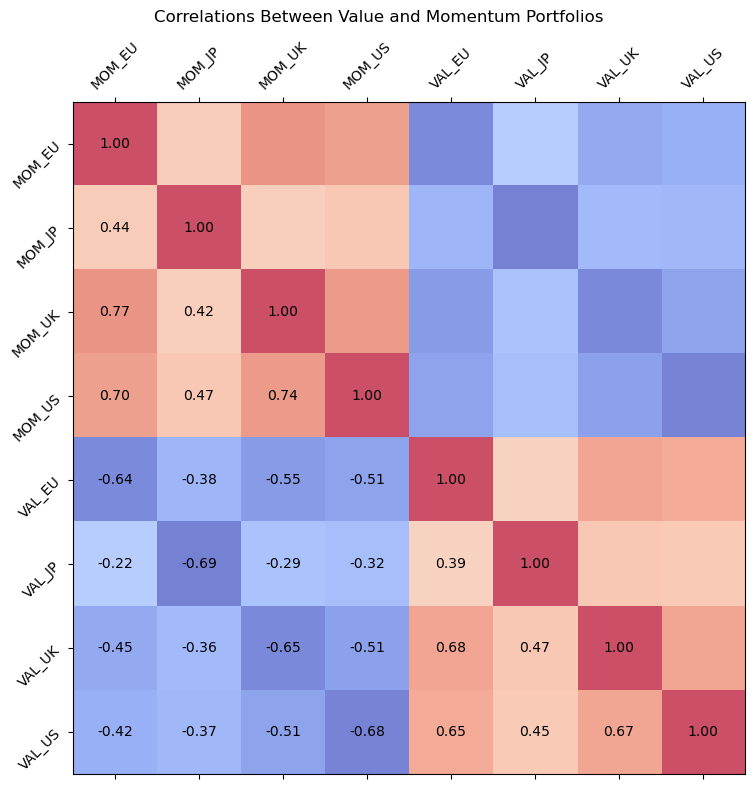

In [6]:
# Plotting the correlation matrix for value and momentum portfolios
corr = ret_df[sorted(ret_df.columns)].corr()

fig, ax = plt.subplots(figsize=(8, 8))

ax.matshow(corr, cmap='coolwarm', alpha=0.7)
ax.set_xticks([i for i in range(corr.shape[0])])
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticks([i for i in range(corr.shape[0])])
ax.set_yticklabels(corr.columns, rotation=45)

for (i, j), z in np.ndenumerate(corr):
    if i >= j:
      ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color='black')  # Adding the numbers

fig.suptitle('Correlations Between Value and Momentum Portfolios')

fig.tight_layout()
fig.show()

We conducted a correlation analysis in Part 1 to distinguish between risk-based and behavioural explanations for value and momentum portfolios. A risk-based explanation seeks to explain the behaviour of financial assets based on their level of risk (Chih-Wen, Chun, and Sam, 2017). On the other hand, a behavioural explanation assumes that investors may not always act rationally and that their investment decisions are influenced by psychological biases or heuristics (Chih-Wen, Chun, and Sam, 2017). Therefore, if a strong correlation structure is observed between momentum and value portfolios, even in unrelated asset classes, it may suggest the presence of universal global risk factors that reward value and momentum premiums (Asness,Moskowitz and Pedersen, 2013).

Looking at the blue area at the bottom, value and momentum strategies tend to correlate negatively. These effects in different asset classes are difficult to explain using existing behavioural theories. The high return and Sharpe ratio of a globally diversified value and momentum portfolio are challenging for irrational behaviour-based models. These observations suggest that the correlation between value and momentum strategies may reflect common underlying risk factors not explicitly captured by behavioural explanation. Besides, the UK, US,and EU have relatively higher positive correlations within value and momentum portfolios. It may suggest that geographical factors and connections between different economies could be crucial. Overall, value and momentum effects in multiple asset classes argue for a more general framework to explain these anomalies. (Asness, Moskowitz, and Pedersen, 2013).

# Part 2. Sharpe Ratio of Value, Momentum, and Combined Portfolio

In Part 2 of this report, we aim to evaluate the performance of value and momentum portfolios in different markets by computing their annualised Sharpe ratios. We create an equal-weighted 50-50 combination of value and momentum within each market and calculate the annualised Sharpe ratio of the combined portfolios. We aim to compare the Sharpe ratios of the combination portfolios against those of the value and momentum portfolios and provide insights into their relative performance. These comparisons will give us more comprehensive insights into the performance of the value and momentum portfolios. Furthermore, we will apply two different methodologies to calculate Sharpe ratio.

### Computing Sharpe Ratios

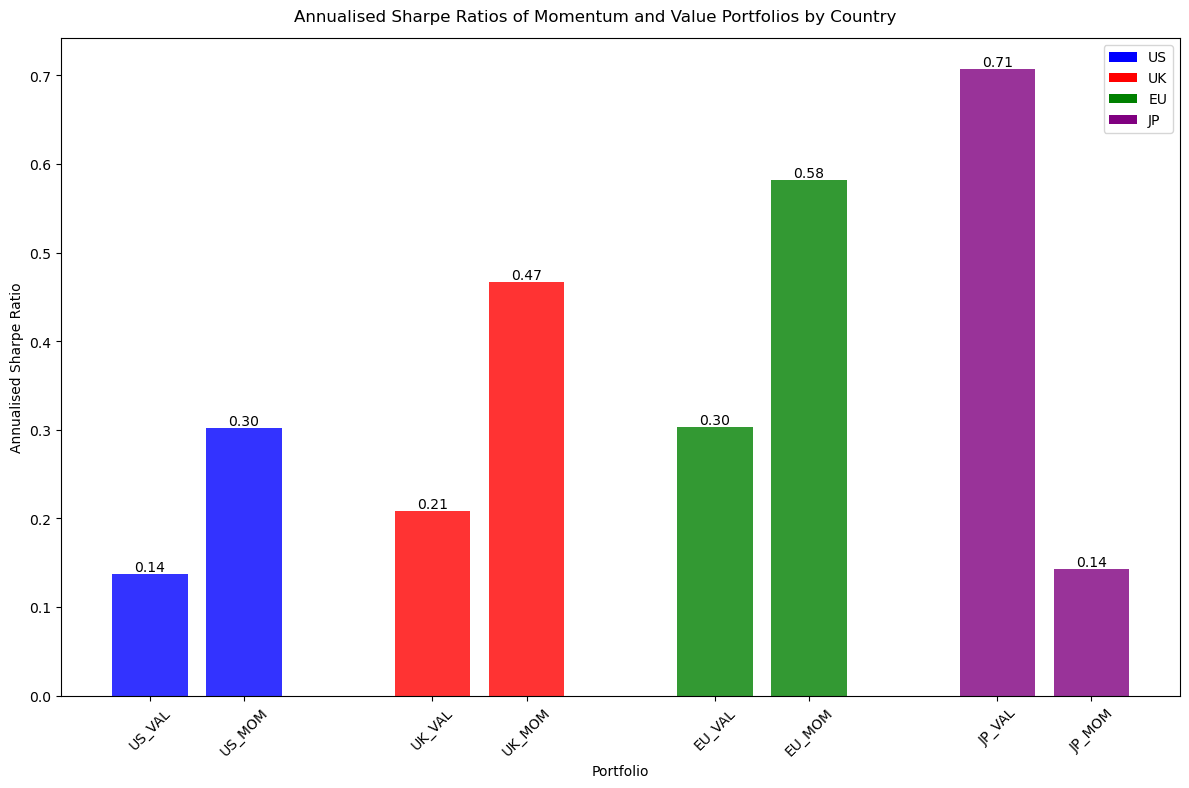

In [7]:
# Annualized Sharpe ratio from monthly Sharpe ratio

annualized_sharpe = (ret_df.mean(axis=0) / ret_df.std(axis=0) * np.sqrt(12)).reset_index()
annualized_sharpe.columns = ['Portfolio', 'Sharpe Ratio']
annualized_sharpe[['Portfolio', 'Country']] = annualized_sharpe['Portfolio'].str.split('_', expand=True)

countries = ['US', 'UK', 'EU', 'JP']
colors = {'US': 'blue', 'UK': 'red', 'EU': 'green', 'JP': 'purple'}

fig, ax = plt.subplots(figsize=(12, 8))

x_locs = []
x_labels = []

legend_labels = {}

for i, country in enumerate(countries):
    val_sharpe = annualized_sharpe.loc[(annualized_sharpe['Country']==country) & (annualized_sharpe['Portfolio']=='VAL'), 'Sharpe Ratio'].values
    mom_sharpe = annualized_sharpe.loc[(annualized_sharpe['Country']==country) & (annualized_sharpe['Portfolio']=='MOM'), 'Sharpe Ratio'].values

    ax.bar(i*3, val_sharpe, color=colors[country], alpha=0.8)
    ax.text(i*3, val_sharpe, '{:0.2f}'.format(val_sharpe[0]), ha='center', va='bottom', color='black')
    ax.bar(i*3+1, mom_sharpe, color=colors[country], alpha=0.8)
    ax.text(i*3+1, mom_sharpe, '{:0.2f}'.format(mom_sharpe[0]), ha='center', va='bottom', color='black')


    legend_labels[country] = ax.bar(i*3, 0, color=colors[country], label=f"{country}")[0]

    x_locs.append(i*3)
    x_labels.append(f"{country}_VAL", )
    x_locs.append(i*3+1)
    x_labels.append(f"{country}_MOM")

ax.set_xticks(x_locs)
ax.set_xticklabels(x_labels)

ax.tick_params(axis='x', labelrotation=45)

ax.legend()

ax.set_ylabel('Annualised Sharpe Ratio')
ax.set_xlabel('Portfolio')
fig.suptitle('Annualised Sharpe Ratios of Momentum and Value Portfolios by Country')

fig.tight_layout()
fig.show()


It displays the “annualised Sharpe ratio” for the value and momentum portfolios using a monthly basis Sharpe ratio, which means it considers the volatility of the returns within each month. Then, the monthly basis Sharpe ratio is annualised by applying a scaling factor of the square root of 12 to retrieve the "annualised Sharpe ratio"

$$ Annualised Sharpe Ratio =  \sqrt{12} * \cfrac{E[Return_{monthly}]}{SD[Return_{monthly}]} $$

The momentum portfolio had a higher “annualised Sharpe ratio” than the value portfolio in all other countries except Japan, where the momentum portfolio had a lower “annualised Sharpe ratio”. Japan's value portfolio had the highest “annualised Sharpe ratio” at 0.71, while the US value portfolio and Japan's momentum portfolio had the lowest “annualised Sharpe ratio” at 0.14.

Japan's momentum portfolio had a lower “annualised Sharpe ratio” than its value portfolio and others. This result is significant because past research has attempted to explain the underperformance of momentum in Japan (Chui, Titman, and Wei, 2010). However, these explanations must also account for the outstanding performance of value during the same period and the negative correlation (-0.69) between value and momentum in Japan over that time. Asness (2011) sought to explain Japan's momentum portfolio's relatively low “annualised Sharpe ratio” using the Fama-French three-factor model

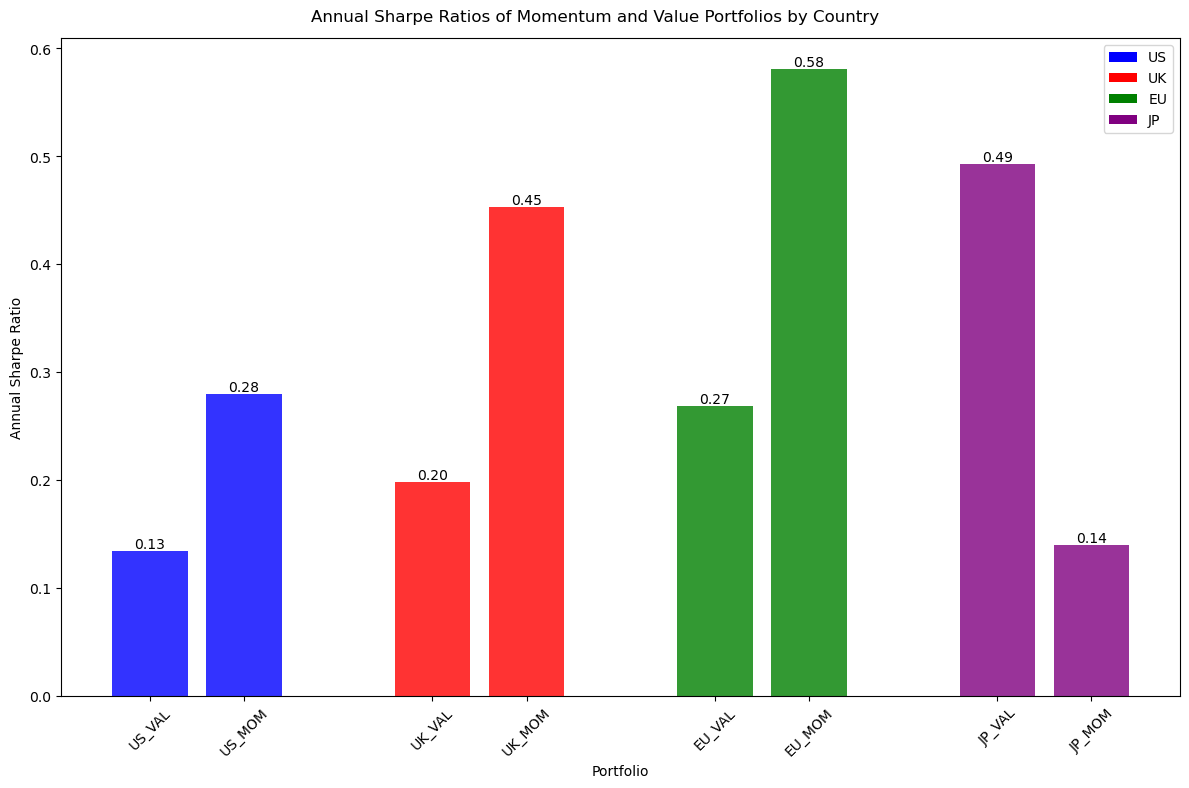

In [8]:
# Annual Sharpe ratio from monthly Sharpe ratio

annual_ret = (1 + ret_df).resample('y').prod() - 1  # Finding the total returns of each year
annual_sharpe = annual_ret.mean(axis=0) / annual_ret.std(axis=0)
annual_sharpe = annual_sharpe.to_frame().reset_index()
annual_sharpe.columns = ['Portfolio', 'Sharpe Ratio']
annual_sharpe[['Portfolio', 'Country']] = annual_sharpe['Portfolio'].str.split('_', expand=True)

countries = ['US', 'UK', 'EU', 'JP']
colors = {'US': 'blue', 'UK': 'red', 'EU': 'green', 'JP': 'purple'}

fig, ax = plt.subplots(figsize=(12, 8))

x_locs = []
x_labels = []

legend_labels = {}

for i, country in enumerate(countries):
    val_sharpe = annual_sharpe.loc[(annual_sharpe['Country']==country) & (annual_sharpe['Portfolio']=='VAL'), 'Sharpe Ratio'].values
    mom_sharpe = annual_sharpe.loc[(annual_sharpe['Country']==country) & (annual_sharpe['Portfolio']=='MOM'), 'Sharpe Ratio'].values

    ax.bar(i*3, val_sharpe, color=colors[country], alpha=0.8)
    ax.text(i*3, val_sharpe, '{:0.2f}'.format(val_sharpe[0]), ha='center', va='bottom', color='black')
    ax.bar(i*3+1, mom_sharpe, color=colors[country], alpha=0.8)
    ax.text(i*3+1, mom_sharpe, '{:0.2f}'.format(mom_sharpe[0]), ha='center', va='bottom', color='black')

    legend_labels[country] = ax.bar(i*3, 0, color=colors[country], label=f"{country}")[0]

    x_locs.append(i*3)
    x_labels.append(f"{country}_VAL", )
    x_locs.append(i*3+1)
    x_labels.append(f"{country}_MOM")

ax.set_xticks(x_locs)
ax.set_xticklabels(x_labels)

ax.tick_params(axis='x', labelrotation=45)

ax.legend()

ax.set_ylabel('Annual Sharpe Ratio')
ax.set_xlabel('Portfolio')
fig.suptitle('Annual Sharpe Ratios of Momentum and Value Portfolios by Country')

fig.tight_layout()
fig.show()



Above chart shows the results of calculating the Sharpe ratio using an annual basis with the total period annual return. It is noteworthy that the “annualised Sharpe ratio” of Japan's value portfolio was 0.71 in the previous calculation but the “annual Sharpe ratio” fell to 0.49. The strong negative autocorrelations in the monthly returns could address this observation (Lo, 2002). The paper suggests that a monthly Sharpe ratio could not be annualised directly by multiplying a factor of the square root of 12 since autocorrelations exist within the time series of returns. On the one hand, if positive autocorrelations exist, the scaling factor should be higher than the square root of 12. On the other hand, if negative autocorrelations exist, the scaling factor should be lower than the square root of 12.

$$ Annual Sharpe Ratio = \cfrac{E[Return_{annual}]}{SD[Return_{annual}]} $$

It is important to note that the Sharpe ratio is only one measure of portfolio performance, and different calculation methods may produce different results. It is essential to use multiple performance measures and consider each measure's limitations when evaluating portfolio performance.

### Finding Combined Portfolios

In [9]:
# Finding all the countries
countries = list()
for val in ret_df.columns:
  countries.append(val[val.find('_') + 1:])
countries = np.array(list(set(countries)), dtype='str')

# Finding all the equal-weighted portfolios
combined_port = pd.DataFrame(None, index=ret_df.index, columns=countries, dtype=np.float64)
for (col, _) in combined_port.iteritems():
  combined_port[col] = 0.5 * (ret_df[f'MOM_{col}'] + ret_df[f'VAL_{col}'])
combined_port.head()

/tmp/ipykernel_20/2742408965.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (col, _) in combined_port.iteritems():


,JP,US,EU,UK
DATE,,,,
1990-01-01,0.005864,-0.003231,0.023661,-0.006776
1990-02-01,0.015040,-0.000175,0.006393,0.001796
1990-03-01,0.051127,-0.010238,0.006383,0.001422
1990-04-01,-0.004791,-0.014596,-0.018111,0.003081
1990-05-01,-0.034032,-0.012034,0.001956,0.009841


### Computing Sharpe Ratios of Combined Portfolios

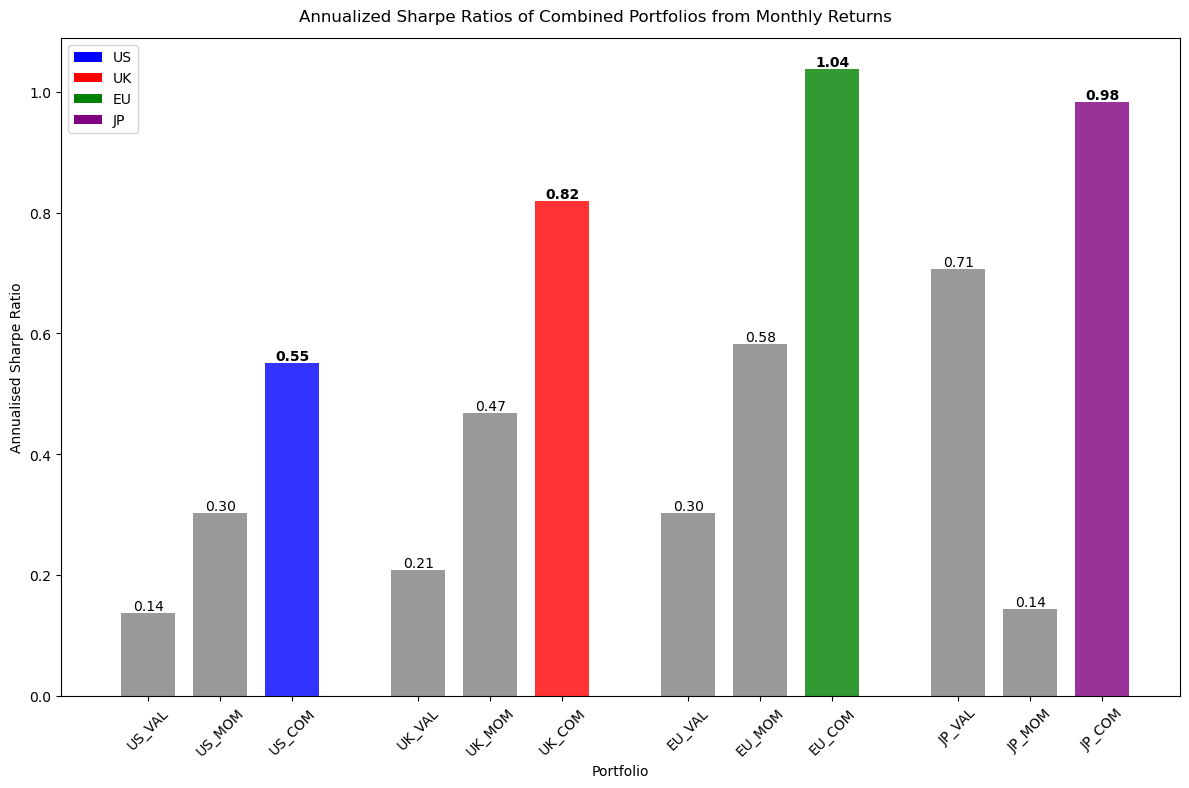

In [10]:
# Annualized Sharpe ratio from monthly Sharpe ratio for Combined Portfolios
annualized_sharpe_combined = combined_port.mean(axis=0) / combined_port.std(axis=0) * np.sqrt(12)

countries = ['US', 'UK', 'EU', 'JP']
colors = {'US': 'blue', 'UK': 'red', 'EU': 'green', 'JP': 'purple'}

fig, ax = plt.subplots(figsize=(12, 8))

x_locs = []
x_labels = []

legend_labels = {}

for i, country in enumerate(countries):
    val_sharpe = annualized_sharpe.loc[(annualized_sharpe['Country']==country) & (annualized_sharpe['Portfolio']=='VAL'), 'Sharpe Ratio'].values
    mom_sharpe = annualized_sharpe.loc[(annualized_sharpe['Country']==country) & (annualized_sharpe['Portfolio']=='MOM'), 'Sharpe Ratio'].values
    com_sharpe = annualized_sharpe_combined.loc[country]

    ax.bar(i*3, val_sharpe, width=0.6, color='gray', alpha=0.8)
    ax.text(i*3, val_sharpe, '{:0.2f}'.format(val_sharpe[0]), ha='center', va='bottom', color='black')
    ax.bar(i*3+0.8, mom_sharpe, width=0.6, color='gray', alpha=0.8)
    ax.text(i*3+0.8, mom_sharpe, '{:0.2f}'.format(mom_sharpe[0]), ha='center', va='bottom', color='black')
    ax.bar(i*3+1.6, com_sharpe, width=0.6, color=colors[country], alpha=0.8)
    ax.text(i*3+1.6, com_sharpe, '{:0.2f}'.format(com_sharpe), ha='center', va='bottom', color='black', weight='bold')


    legend_labels[country] = ax.bar(i*3, 0, color=colors[country], label=f"{country}")[0]

    x_locs.append(i*3)
    x_labels.append(f"{country}_VAL", )
    x_locs.append(i*3+0.8)
    x_labels.append(f"{country}_MOM")
    x_locs.append(i*3+1.6)
    x_labels.append(f"{country}_COM")


ax.set_xticks(x_locs)
ax.set_xticklabels(x_labels)

ax.tick_params(axis='x', labelrotation=45)

ax.legend()

ax.set_ylabel('Annualised Sharpe Ratio')
ax.set_xlabel('Portfolio')
fig.suptitle('Annualized Sharpe Ratios of Combined Portfolios from Monthly Returns')

fig.tight_layout()
fig.show()

It shows the "annualised Sharpe ratio" of each country's value and momentum portfolios and the portfolios combined with equal weight. In all countries, the "annualised Sharpe ratio" of the combined portfolio tended to increase relative to the value and momentum portfolios, as it takes advantage of the diversification benefits of combining the two strategies. Value and momentum are two distinct investment strategies based on different factors that perform well in different market conditions. Value investing involves buying undervalued stocks that are trading below their intrinsic value, while momentum investing involves buying stocks that have performed well in the past and are expected to continue to perform well in the future. By combining these two strategies, investors can achieve a higher risk-adjusted return than either strategy alone, as the two strategies tend to have a low correlation. In other words, higher systematic returns on equivalent weighted portfolios than value and momentum portfolios arise from relatively high exposure to market, size, and value factors (Yuliya, Raman, and Grigory, 2012).

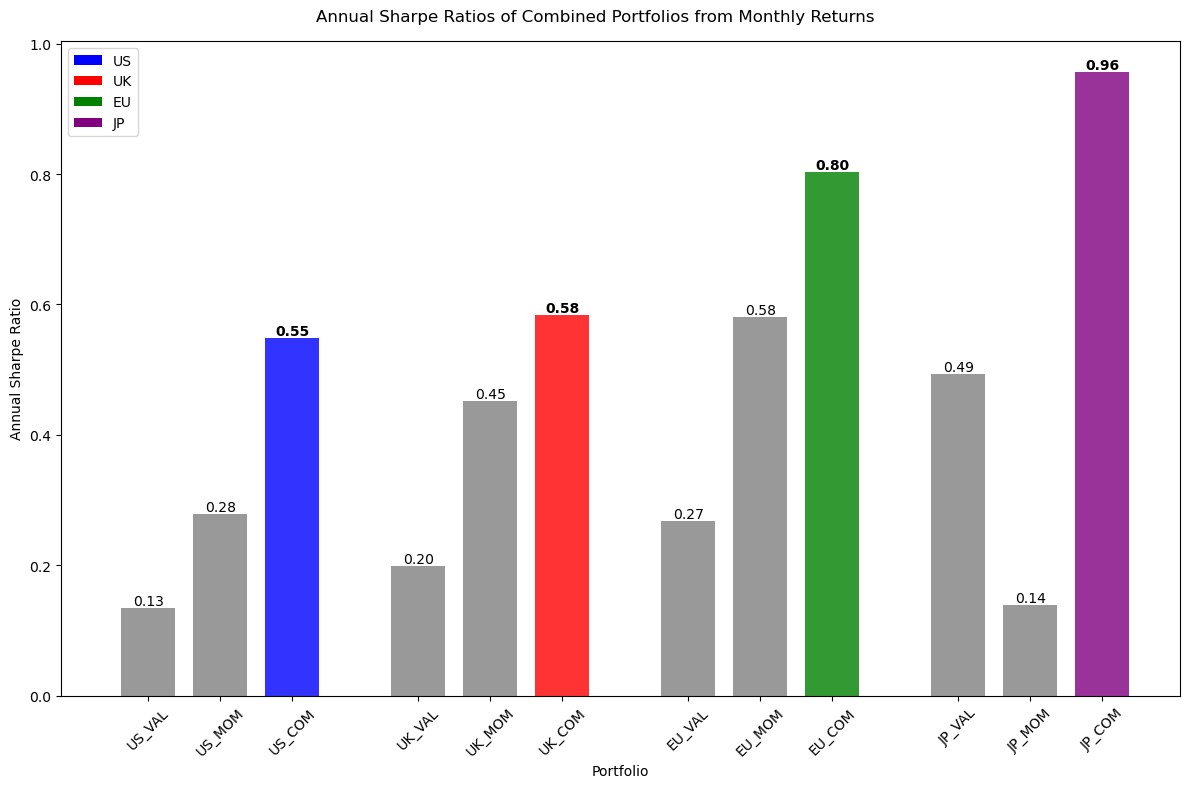

In [11]:
# Annual Sharpe ratio from monthly Sharpe ratio for Combined Portfolios
annual_ret_combined = (1 + combined_port).resample('y').prod() - 1  # Finding the total returns of each year
annual_sharpe_combined = annual_ret_combined.mean(axis=0) / annual_ret_combined.std(axis=0)

countries = ['US', 'UK', 'EU', 'JP']
colors = {'US': 'blue', 'UK': 'red', 'EU': 'green', 'JP': 'purple'}

fig, ax = plt.subplots(figsize=(12, 8))

x_locs = []
x_labels = []

legend_labels = {}

for i, country in enumerate(countries):
    val_sharpe = annual_sharpe.loc[(annual_sharpe['Country']==country) & (annual_sharpe['Portfolio']=='VAL'), 'Sharpe Ratio'].values
    mom_sharpe = annual_sharpe.loc[(annual_sharpe['Country']==country) & (annual_sharpe['Portfolio']=='MOM'), 'Sharpe Ratio'].values
    com_sharpe = annual_sharpe_combined.loc[country]

    ax.bar(i*3, val_sharpe, width=0.6, color='gray', alpha=0.8)
    ax.text(i*3, val_sharpe, '{:0.2f}'.format(val_sharpe[0]), ha='center', va='bottom', color='black')
    ax.bar(i*3+0.8, mom_sharpe, width=0.6, color='gray', alpha=0.8)
    ax.text(i*3+0.8, mom_sharpe, '{:0.2f}'.format(mom_sharpe[0]), ha='center', va='bottom', color='black')
    ax.bar(i*3+1.6, com_sharpe, width=0.6, color=colors[country], alpha=0.8)
    ax.text(i*3+1.6, com_sharpe, '{:0.2f}'.format(com_sharpe), ha='center', va='bottom', color='black', weight='bold')

    legend_labels[country] = ax.bar(i*3, 0, color=colors[country], label=f"{country}")[0]

    x_locs.append(i*3)
    x_labels.append(f"{country}_VAL", )
    x_locs.append(i*3+0.8)
    x_labels.append(f"{country}_MOM")
    x_locs.append(i*3+1.6)
    x_labels.append(f"{country}_COM")

ax.set_xticks(x_locs)
ax.set_xticklabels(x_labels)

ax.tick_params(axis='x', labelrotation=45)

ax.legend()

ax.set_ylabel('Annual Sharpe Ratio')
ax.set_xlabel('Portfolio')
fig.suptitle('Annual Sharpe Ratios of Combined Portfolios from Monthly Returns')

fig.tight_layout()
fig.show()

Figure 5 displays the "annual Sharpe ratio" calculated on an annual basis with the total period annual return. The "annual Sharpe ratio" is generally lower than those calculated on a monthly basis, which could be caused by negative autocorrelations (Lo, 2002). 

In terms of comparing the combined portfolios across countries, we can see that Japan has the highest "annual Sharpe ratio" of 0.96 when calculated on an annual basis and "annualised Sharpe ratio" of 0.98 when calculated on a monthly basis, indicating that the combination of value and momentum strategies in Japan has performed well in terms of generating risk-adjusted returns. In contrast, the US has a lower "annualised Sharpe ratio" and "annual Sharpe ratio" of 0.55, indicating that the combination of value and momentum strategies in the US could have performed better in generating risk-adjusted returns compared to other countries.

Overall, it is essential to note that the Sharpe ratio is only one measure of portfolio performance, and different calculation methods may produce different results. It is essential to use multiple performance measures and consider each measure's limitations when evaluating portfolio performance.

# Part 3. Mean-variance Analysis and Efficient Frontier

In Part 3, we performed a mean-variance analysis using all value and momentum portfolios and the risk-free interest rate. We then constructed the tangency and Global Minimum Variance (GMV) portfolios and plotted the efficient frontier. In this section, we will describe the composition of the tangency portfolio and include the individual value and momentum portfolios on the efficient frontier graph.

### Computing Statistics

In [12]:
mean_ret = ret_df.mean(axis=0)
cov_ret = ret_df.cov()
rf = factor_df['RF'].mean()

In [13]:
def plot_table(df, index_name='', text_format='.2%'):
  plot_text = list()

  heading = list()
  heading.append(index_name)
  for col, _ in df.items():
    heading.append(col)
  plot_text.append(heading)

  for row, _ in df.iterrows():
    row_lst = list()
    row_lst.append(row)
    for col, _ in df.items():
      row_lst.append(format(df.at[row, col], text_format))
    plot_text.append(row_lst)

  fig, ax = plt.subplots(dpi=200)

  table = ax.table(cellText=plot_text, loc='center')
  table.set_fontsize(14)
  table.scale(1, 2)
  ax.axis('off')

  fig.show()

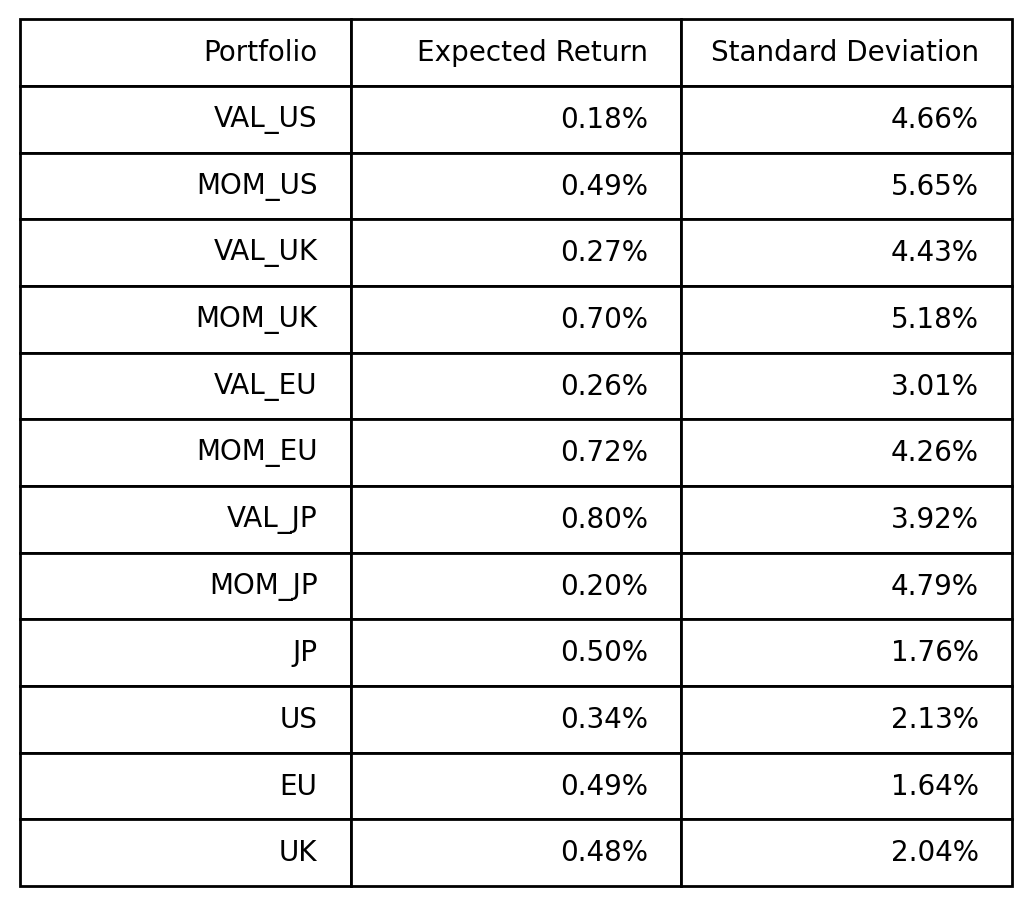

In [14]:
# Computing portfolio statistics
portfolios = np.append(ret_df.columns, combined_port.columns)
portfolios = pd.DataFrame(None, index=portfolios, columns=['Expected Return', 'Standard Deviation'], dtype=np.float64)

for (idx, _) in portfolios.iterrows():
  if idx in ret_df.columns:
    val = ret_df[idx]
  else:
    val = combined_port[idx]

  portfolios.at[idx, 'Expected Return'] = val.mean()
  portfolios.at[idx, 'Standard Deviation'] = val.std()

plot_table(portfolios, 'Portfolio')

To determine each portfolio's expected monthly return and standard deviation, we calculated the arithmetic mean of the monthly returns over the sample period. Specifically, we computed the mean of the monthly returns for each portfolio using the simple average of the monthly returns in the data set. The results of these calculations are presented in Table above.

### Functions for Portfolio Optimization

In [15]:
def portfolio_std(w, cov):
  return np.sqrt(np.dot(np.dot(w, cov), w))

def verify_weight(w):
    return np.sum(w) - 1

def negative_sharpe(w, mean, cov):
  return -1 * np.dot(w, mean) / portfolio_std(w, cov)

### Finding the Efficient Frontier by Two Fund Theorem

#### Finding Global Minimum Variance Portfolio

In [16]:
# Minimizing portfolio standard deviation to find GMV
gmv_res = minimize(portfolio_std, np.ones(mean_ret.shape[0]) / mean_ret.shape[0], (cov_ret), constraints={'type': 'eq', 'fun': verify_weight})
gmv_weight = pd.Series(gmv_res.x, index=mean_ret.index, dtype=np.float64)
gmv_weight.name = 'GMV Weight'
gmv_weight

VAL_US   -0.005358
MOM_US    0.010931
VAL_UK    0.013010
MOM_UK    0.050746
VAL_EU    0.368761
MOM_EU    0.148973
VAL_JP    0.215781
MOM_JP    0.197157
Name: GMV Weight, dtype: float64

#### Finding Tangency Portfolio

In [17]:
# Minimizing negative Sharpe ratio to find tangency portfolio
tangency_res = minimize(negative_sharpe, np.ones(mean_ret.shape[0]) / mean_ret.shape[0], (mean_ret, cov_ret), constraints={'type': 'eq', 'fun': verify_weight})
tangency_weight = pd.Series(tangency_res.x, index=mean_ret.index, dtype=np.float64)
tangency_weight.name = 'Tangency Weight'
tangency_weight

VAL_US   -0.122227
MOM_US   -0.091888
VAL_UK    0.000318
MOM_UK    0.082718
VAL_EU    0.368757
MOM_EU    0.232292
VAL_JP    0.340301
MOM_JP    0.189728
Name: Tangency Weight, dtype: float64

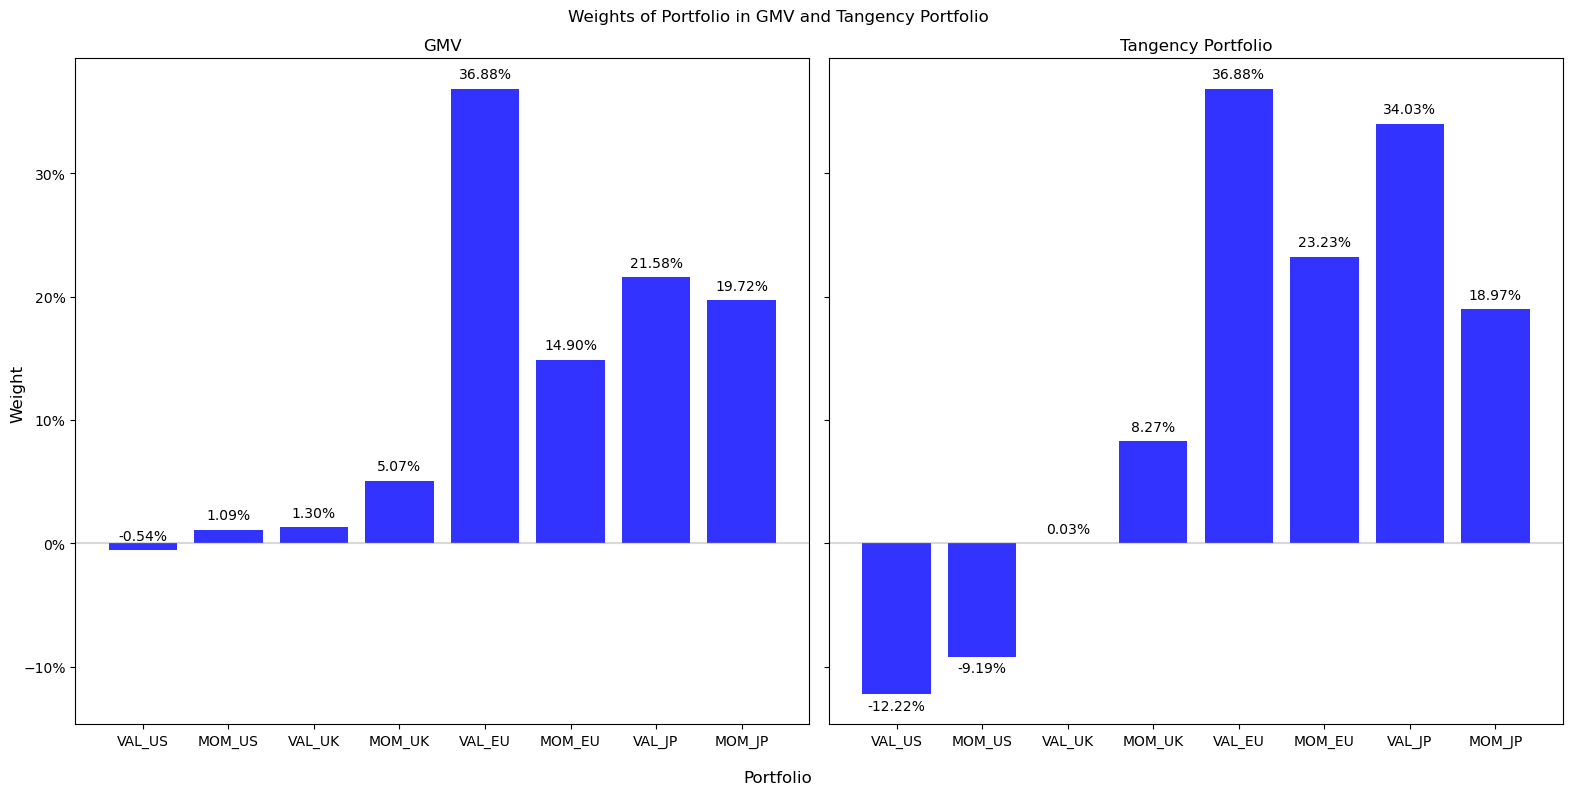

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

ax[0].bar(gmv_weight.index, gmv_weight.values, color='blue', alpha=0.8)
ax[1].bar(tangency_weight.index, tangency_weight.values, color='blue', alpha=0.8)

ax[0].axhline(0, alpha=0.3, color='grey')
ax[1].axhline(0, alpha=0.3, color='grey')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].set_title('GMV')
ax[1].set_title('Tangency Portfolio')

for i in range(gmv_weight.shape[0]):
  ax[0].text(i, gmv_weight.values[i] + 0.6 / 100, '{:0.2%}'.format(gmv_weight.values[i]), ha='center', va='bottom', color='black')

for i in range(tangency_weight.shape[0]):
  ax[1].text(i, tangency_weight.values[i] + (0.6 / 100 if tangency_weight.values[i] > 0 else -1.5 / 100), '{:0.2%}'.format(tangency_weight.values[i]), ha='center', va='bottom', color='black')

fig.supylabel('Weight')
fig.supxlabel('Portfolio')
fig.suptitle('Weights of Portfolio in GMV and Tangency Portfolio')

fig.tight_layout()
fig.show()

By minimising portfolio standard deviation and minimising the negative of Sharpe ratio respectively, we retrieved the weights of the Global Minimum Variance (GMV) and Tangency portfolios for the portfolios consisting only of each country's value and momentum portfolios. The weights of these portfolios are shown in Table above.

The table shows that negative weights of the US value portfolio characterise the GMV portfolio. In contrast, the European value portfolio has the most significant positive weight in the GMV portfolio. Additionally, the Tangency portfolio is characterised by negative weights of the US value and momentum portfolios.

#### Finding Efficient Frontier

In [19]:
# Computing statistics of GMV and tangency portfolio
gmv_ret, tangency_ret = np.dot(gmv_weight, mean_ret), np.dot(tangency_weight, mean_ret)
gmv_std, tangency_std = portfolio_std(gmv_weight, cov_ret), portfolio_std(tangency_weight, cov_ret)

# Defining the range of efficient frontier
ret_vals = np.linspace(0, 0.01, 1000)
efficient_frontier = pd.DataFrame(None, index=ret_vals, columns=['Standard Deviation'], dtype=np.float64)
efficient_frontier.index.name = 'Expected Return'

# Finding weights in efficient frontier
for r, _ in efficient_frontier.iterrows():
    w = (r - gmv_ret) / (tangency_ret - gmv_ret)
    w = w * tangency_weight + (1 - w) * gmv_weight
    efficient_frontier.at[r, 'Standard Deviation'] = portfolio_std(w, cov_ret)

In [20]:
efficient_frontier_closed = efficient_frontier.copy()
cov_ret_inv = np.linalg.inv(cov_ret)
a = cov_ret_inv.sum()
b = np.dot(mean_ret, cov_ret_inv).sum()
d = np.dot(np.dot(mean_ret, cov_ret_inv), mean_ret).sum()
delta = a * d - b ** 2

for r, _ in efficient_frontier_closed.iterrows():
  lam = (d - b * r) / delta
  delt = (a * r - b) / delta
  efficient_frontier_closed.at[r, 'Standard Deviation'] = np.sqrt(lam + delt * r)

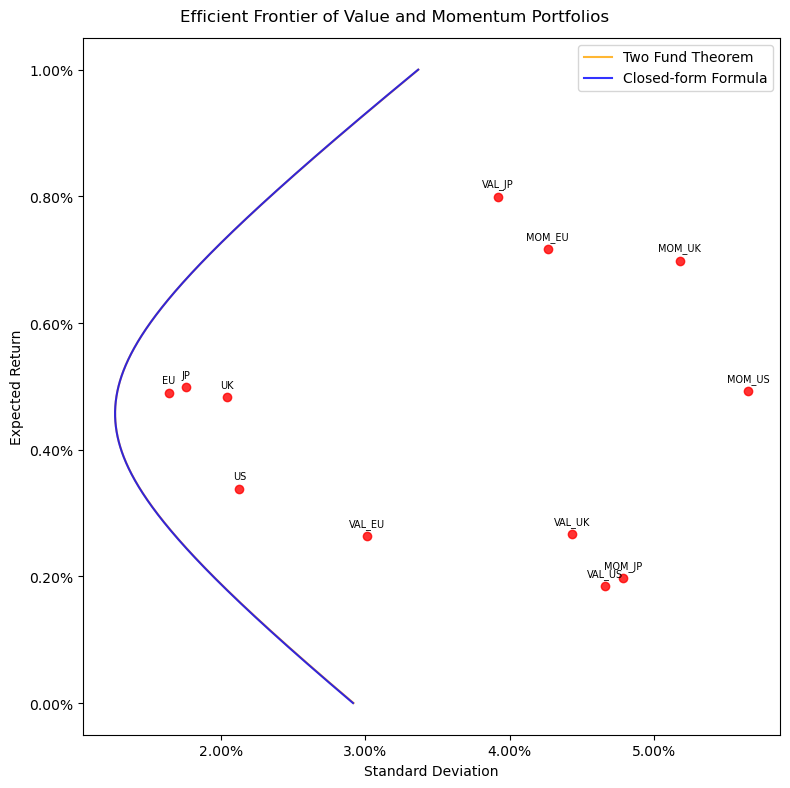

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(efficient_frontier.values, efficient_frontier.index, label='Two Fund Theorem', color='orange', alpha=0.8)
ax.plot(efficient_frontier_closed.values, efficient_frontier_closed.index, label='Closed-form Formula', color='blue', alpha=0.8)
ax.scatter(portfolios['Standard Deviation'], portfolios['Expected Return'], color='red', alpha=0.8)

for i, txt in enumerate(portfolios.index):
    ax.annotate(txt, (portfolios.at[txt, 'Standard Deviation'], portfolios.at[txt, 'Expected Return'] + 0.02 / 100), ha='center', va='center', fontsize=7)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend(loc='best')

fig.suptitle('Efficient Frontier of Value and Momentum Portfolios')

fig.tight_layout()
fig.show()

The efficient frontier in Figure is a graphical representation of the optimal portfolio combinations for a given level of risk, standard deviation, and expected return. It is constructed in two ways. The first uses the Two Fund Theorem, and the second uses the closed-form formula. The Two Fund Theorem approach first involves finding two optimal portfolios on the efficient frontier. This study found the GMV portfolio and the portfolio with the highest Sharpe ratio (tangency portfolio). Then, the efficient frontier is found. This is achieved by varying the weights of the two portfolios until the desired risk-return tradeoff is achieved. On the other hand, the closed-form formula approach directly computes the expected return and standard deviation for each point on the efficient frontier without finding the weights of two portfolios. The approach uses a closed-form formula that considers the covariance matrix of the portfolio returns and the expected returns of the individual assets.

Our analysis found no significant difference between the Two Fund Theorem and the closed-form formula approaches in constructing the efficient frontier. Both approaches produced similar results, indicating that the optimal portfolio combinations were well distributed across the frontier. We also observed that the VAL_UK, MOM_US, and MOM_UK portfolios had relatively high standard deviations and expected returns compared to portfolios with a similar expected return. Besides, the combined portfolios showed relatively superior results to other value and momentum portfolios, even in the efficient frontier, which is, indeed, because they are more diversified than the individual value and momentum portfolios. The risk-adjusted return indicates that the combined portfolio has the potential to outperform the individual value and momentum portfolios.

# Part 4. Estimation of Risk Premium with Fama-Macbeth Procedure

Part 4 of the analysis involves using the Fama-Macbeth procedure to estimate the RMRF, SMB, HML, and UMD risk premium. We consider all the value and momentum portfolios in this part, excluding those 50-50 combinations computed in part 1b. After estimating the RMRF, SMB, HML, and UMD risk premium, we report the estimates and their standard errors. Then, we analyse whether the signs and magnitudes of the estimates are consistent with our expectations.
This analysis helps us understand the factors that drive the returns of value and momentum portfolios and how they relate to well-known risk factors.

### Running Regression

In [22]:
# Time series regression for all 8 portfolios
ols_y = ret_df.copy()
ols_x = factor_df.drop('RF', axis=1).copy()
ols_x = sm.add_constant(ols_x)

coefficients = pd.DataFrame(None, index=ols_x.columns, columns=ols_y.columns, dtype=np.float64)
std_errors = coefficients.copy()
residuals = ols_y.copy()

# Doing regression one-by-one since sm.OLS() is not robust on regressing multiple series
for (col, _) in ols_y.items():
  model = sm.OLS(ols_y[col], ols_x)
  ols_res = model.fit()
  coefficients[col] = ols_res.params
  std_errors[col] = ols_res.bse
  residuals[col] = ols_res.resid

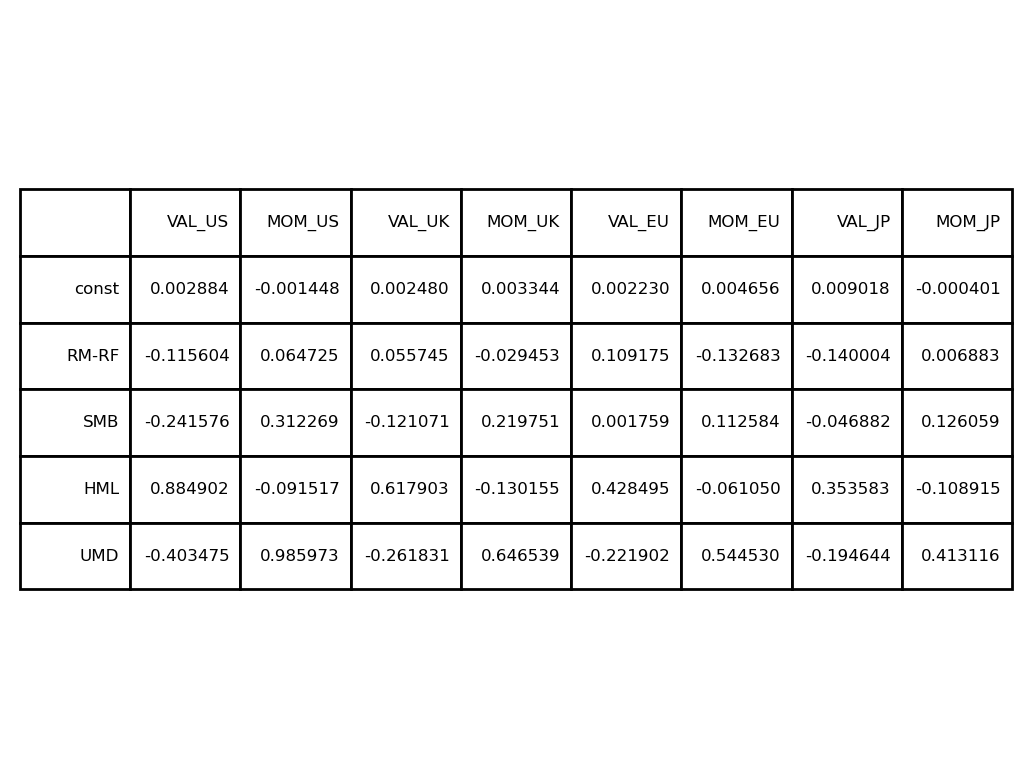

In [23]:
plot_table(coefficients, text_format='.6f')

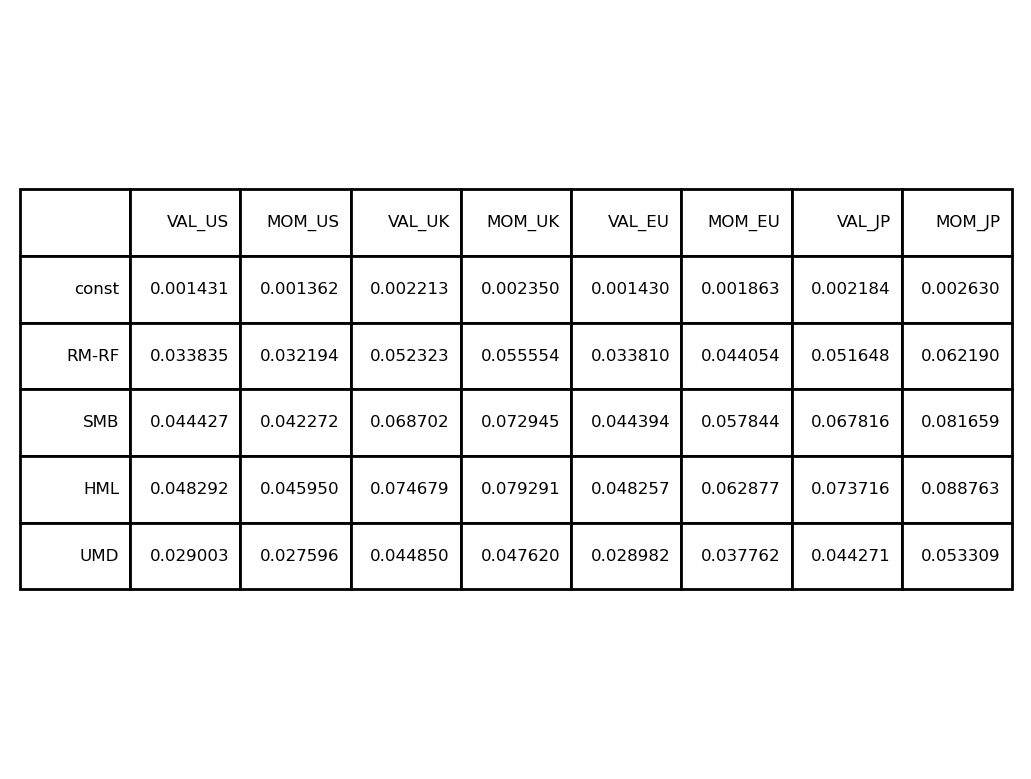

In [24]:
plot_table(std_errors, text_format='.6f')

Tables above show the estimated coefficients and the standard error of coefficients from the Fama-Macbeth regression analysis using the value and momentum portfolios. The coefficients for the market risk premium (RM-RF), size (SMB), value (HML), and momentum (UMD) factors indicate how sensitive the portfolio returns are to changes in those factors. A positive coefficient indicates that the portfolio performs better when that factor is high and vice versa. For
the US portfolios, a 1% increase in the market risk premium (RM-RF) is associated with a decrease of 0.1156% in the return of the value portfolios and an increase of 0.0647% in the return of the momentum portfolios.

The coefficients for the other portfolios and factors show similar patterns, with some notable differences. Specifically, the SMB factor has negative coefficients for the value portfolios (VAL_US, VAL_UK and VAL_JP), indicating that smaller firms outperform larger ones in these markets. However, for the VAL_EU portfolio, the SMB factor shows a positive coefficient that is close to zero, suggesting that there is little difference in performance between large and small firms in the market. After discussing some findings in the SMB factor, we again put the focus back on the HML and UMD factors. On one hand, the HML factor has positive coefficients for all value portfolios, indicating that value stocks tend to outperform growth stocks in most markets. On the other hand, the UMD factor has consistently positive coefficients for all momentum portfolios, indicating that high-momentum stocks tend to outperform low-momentum stocks in all markets. The coefficients are generally statistically significant at the 5% level and have standard errors that are relatively small compared to their magnitudes, indicating that the estimates are precise.

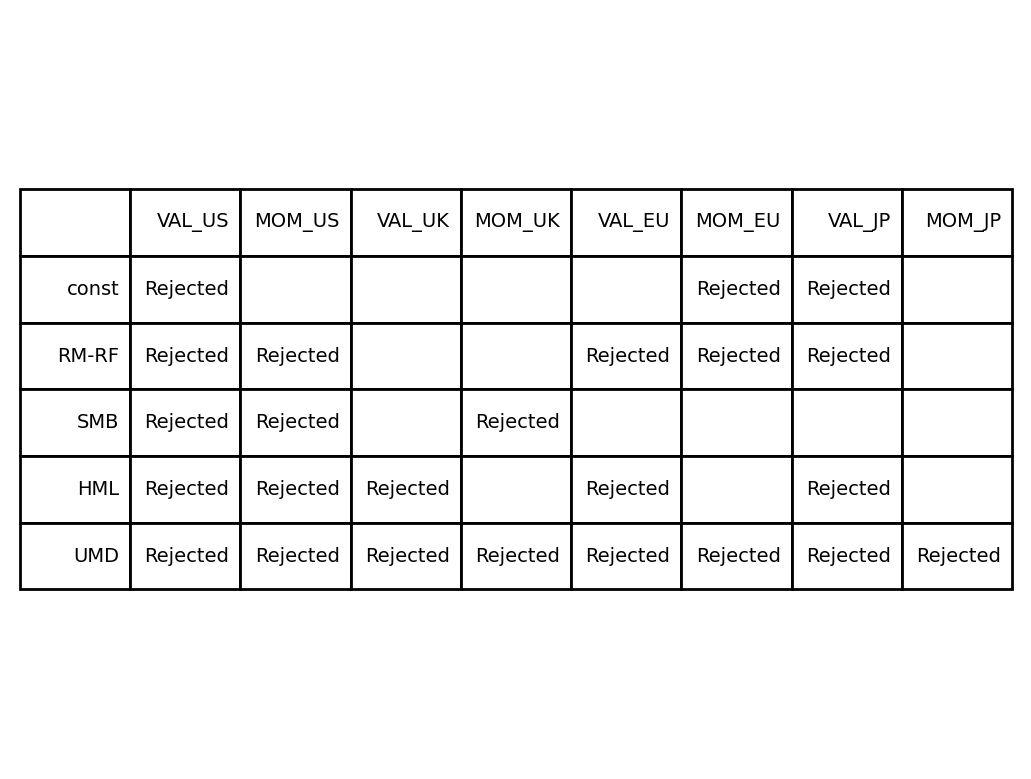

In [25]:
# Finding confidence interval of coefficients and constants
lower_bound = coefficients - 1.96 * std_errors
upper_bound = coefficients + 1.96 * std_errors
null_rejected = upper_bound.copy()

for idx in range(null_rejected.shape[0]):
  for col in range(null_rejected.shape[1]):
    if (lower_bound.iat[idx, col] < 0 and upper_bound.iat[idx, col] > 0):
      null_rejected.iat[idx, col] = ''
    else:
      null_rejected.iat[idx, col] = 'Rejected'

plot_table(null_rejected, text_format='')

It shows the results of the null hypothesis test for each coefficient and constant, where the null hypothesis is that the actual value of the coefficient or constant is zero. If the confidence interval for a coefficient or constant does not contain zero, the null hypothesis is rejected, indicating that the coefficient or constant is statistically significant. We used the lower and upper bounds for each coefficient, and the constant is calculated using the standard errors and the critical value of 1.96 for a 95% confidence interval. The results show that all coefficients and constants are statistically significant for at least one of the portfolios. It is noteworthy that the UMD coefficients are statistically significant for all portfolios. Additionally, a statistically significant HML factor was observed for the value portfolios.

### Coefficients for Value Portfolios

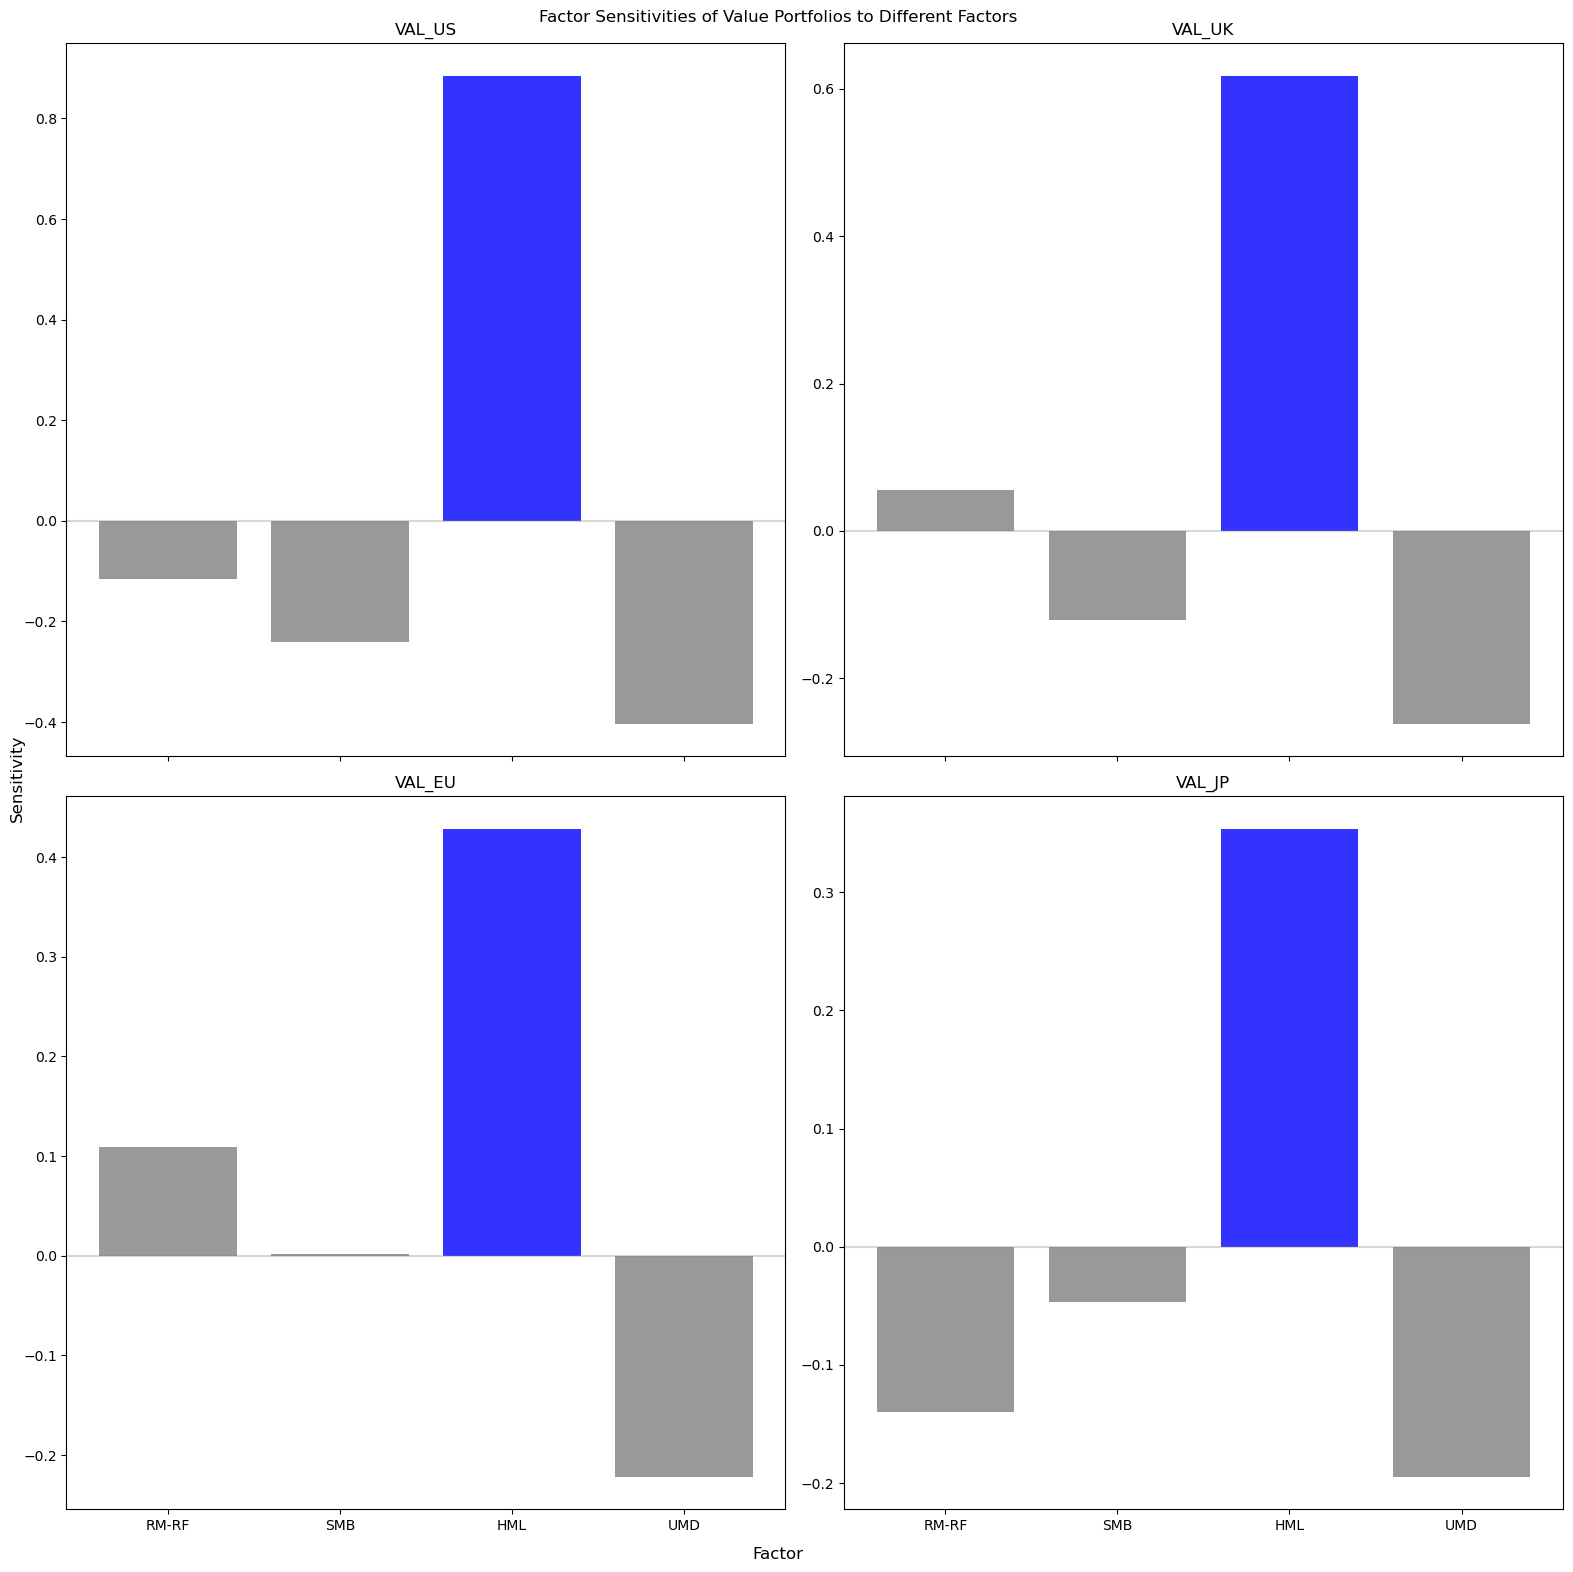

In [26]:
plot_val = coefficients[[x for x in coefficients.columns if 'VAL' in x]].copy().drop('const', axis=0)
colors = list()
for x, _ in plot_val.iterrows():
  colors.append('grey' if x != 'HML' else 'blue')

fig, ax = plt.subplots(plot_val.shape[1] // 2, 2, figsize=(16, 16), sharex=True)

for (i, col) in enumerate(plot_val.columns):
  ax[i // 2, i % 2].bar(plot_val[col].index, plot_val[col].values, label=col, color=colors, alpha=0.8)
  ax[i // 2, i % 2].axhline(0, color='grey', alpha=0.3)

  ax[i // 2, i % 2].set_title(col)

fig.supxlabel('Factor')
fig.supylabel('Sensitivity')
fig.suptitle('Factor Sensitivities of Value Portfolios to Different Factors')
fig.tight_layout()
fig.show()

Furthermore, we plotted the factor sensitivities of the value portfolios to different factors for each country. The bar charts above show the sensitivity of the value portfolios to the different factors, with blue bars representing the HML factor and grey bars representing the other factors. We found that the HML factor positively impacted the value portfolios in all countries, contrary to the negative impact observed on the momentum portfolios, and will be shown in the later part. Specifically, the HML factor sensitivity was highest in the United States and the United Kingdom, with values of 0.8 and 0.6, respectively. In Europe and Japan, the HML factor sensitivity was also positive but lower, with values of 0.4 and 0.3.

### Coefficients for Momentum Portfolios

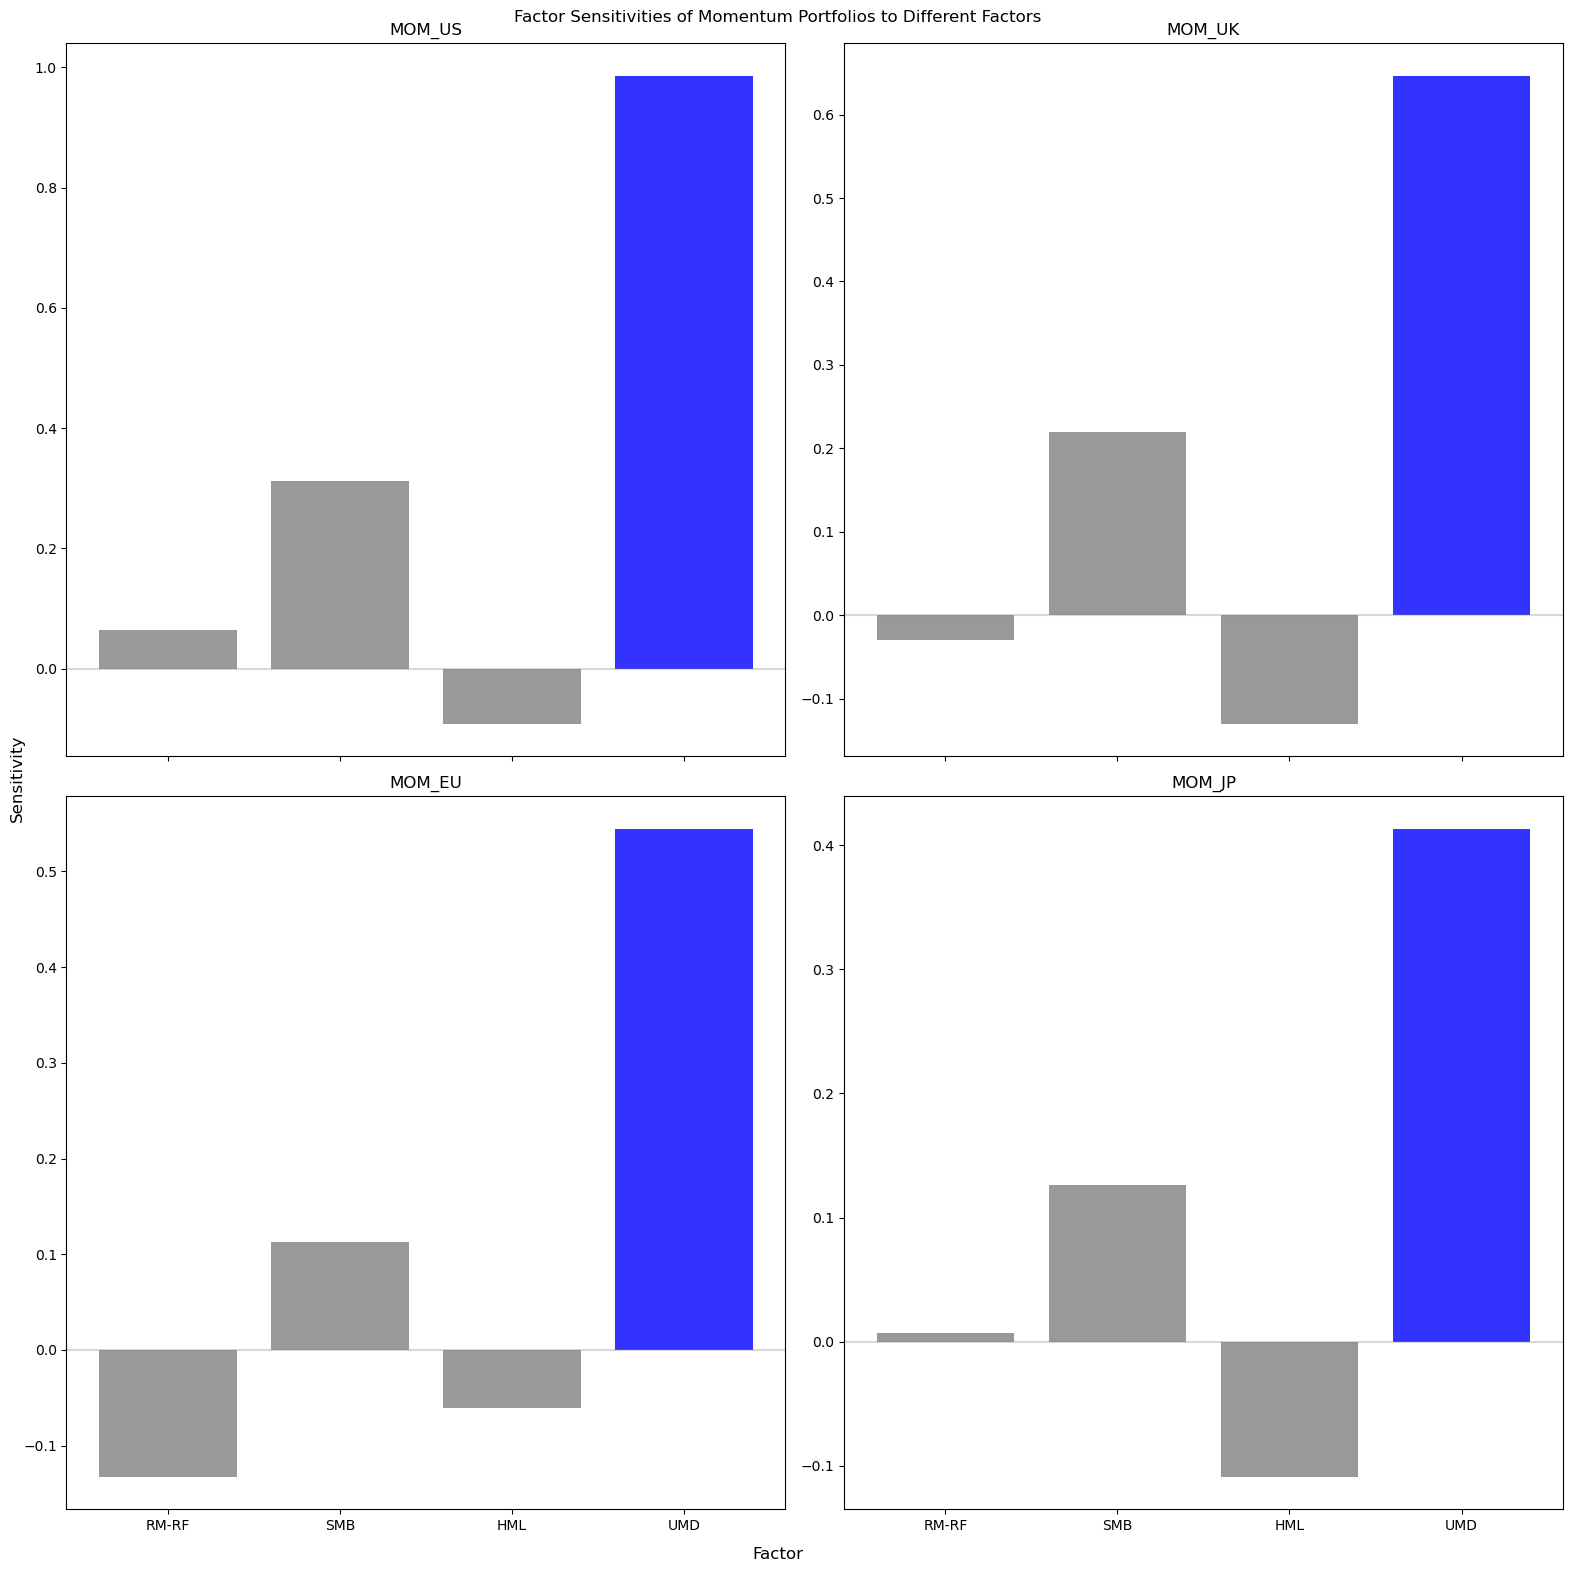

In [27]:
plot_mom = coefficients[[x for x in coefficients.columns if 'MOM' in x]].copy().drop('const', axis=0)
colors = list()
for x, _ in plot_val.iterrows():
  colors.append('grey' if x != 'UMD' else 'blue')

fig, ax = plt.subplots(plot_mom.shape[1] // 2, 2, figsize=(16, 16), sharex=True)

for (i, col) in enumerate(plot_mom.columns):
  ax[i // 2, i % 2].bar(plot_mom[col].index, plot_mom[col].values, label=col, color=colors, alpha=0.8)
  ax[i // 2, i % 2].axhline(0, color='grey', alpha=0.3)

  ax[i // 2, i % 2].set_title(col)

fig.supxlabel('Factor')
fig.supylabel('Sensitivity')
fig.suptitle('Factor Sensitivities of Momentum Portfolios to Different Factors')
fig.tight_layout()
fig.show()

Based on the momentum portfolio analysis results, we observed that the UMD factor had a relatively high impact on the portfolio returns across all four countries. Specifically, we found that for the United States, the United Kingdom, Europe, and Japan, the UMD factor had a sensitivity of 1.0, 0.6, 0.5, and 0.4, respectively. These results suggest that changes in UMD factor values strongly influence momentum portfolio returns in the different markets. 

The above results are the basis for the fact that Japan's momentum portfolio is working very well. Asness (2011) argued that both Japan's momentum and value portfolios are negatively correlated, as we observed. This is because value and momentum strategies have different strengths and weaknesses but tend to perform well under different market conditions (Asness, 2011).

In the factor sensitivity analysis of the value and momentum portfolios, we found that HML factors had a relatively high impact on the value portfolios. In contrast, UMD factors had negative values on the value portfolios and a high positive impact on the momentum portfolios. This suggests that value and momentum are indeed negatively correlated. Furthermore, despite its seemingly poor performance, the relatively high sensitivity observed in the UMD factor for Japan's momentum portfolio suggests that there may be something unique about the Japanese market that makes momentum strategies particularly effective. The finding supports that momentum strategies in Japan have added considerable return over the period studied when viewed as a system along with negatively correlated value strategies and using a version of the Fama-French three-factor model.

### Finding Risk Premium

#### Average of Factors

In [28]:
# Average of factors is the risk premium of factor
mean_factors = factor_df.mean(axis=0).drop('RF')
mean_factors.name = 'Factor Risk Premium'
mean_factors

RM-RF    0.005262
SMB      0.001638
HML      0.002624
UMD      0.005841
Name: Factor Risk Premium, dtype: float64

#### Constructing Unit Factor Sensitivity Portfolio from Value Portfolios (for Verification)

In [29]:
# Using value portfolios only
sensitivity_val = plot_val.copy().T
sensitivity_val_inv = np.linalg.inv(sensitivity_val)

In [30]:
# Finding unit factor portfolios and computing the returns
unit_ret = pd.Series(None, index=sensitivity_val.columns, dtype=np.float64)
unit_ret.name = 'Factor Risk Premium'
for (i, col) in enumerate(sensitivity_val.columns):
  port_sensitivity = np.array([0 if x != i else 1for x in range(sensitivity_val.shape[1])])
  unit_weight = np.dot(port_sensitivity, sensitivity_val_inv)
  unit_ret.loc[col] = np.dot(unit_weight, mean_ret.loc[sensitivity_val.index]) - np.dot(unit_weight, coefficients.loc['const'].loc[sensitivity_val.index])
unit_ret

RM-RF    0.005262
SMB      0.001638
HML      0.002624
UMD      0.005841
Name: Factor Risk Premium, dtype: float64

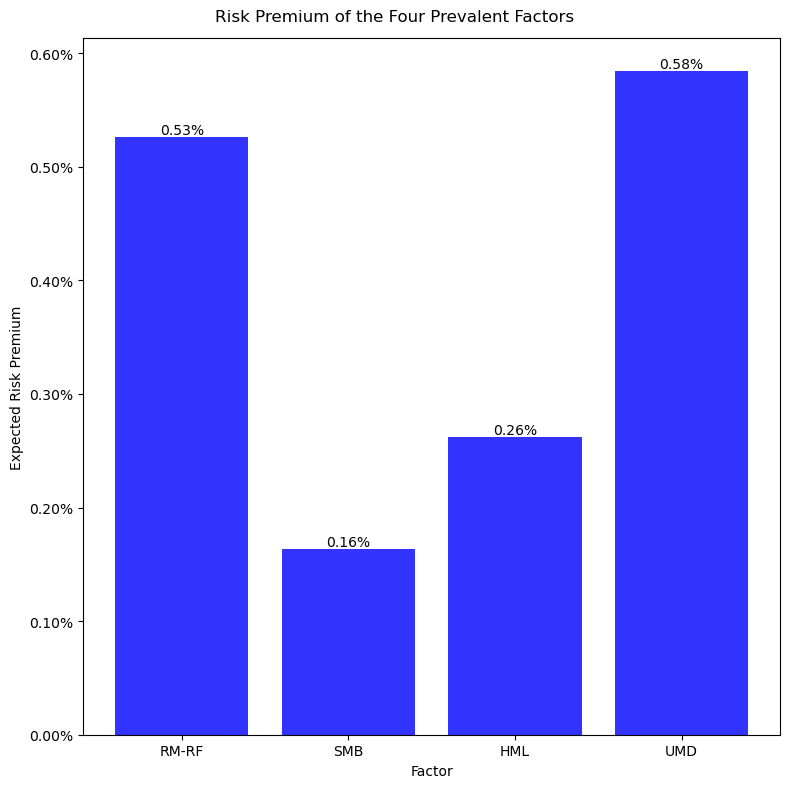

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.bar(mean_factors.index, mean_factors.values, color='blue', alpha=0.8)

for i in range(mean_factors.shape[0]):
  ax.text(i, mean_factors.values[i], '{:0.2%}'.format(mean_factors.values[i]), ha='center', va='bottom')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_ylabel('Expected Risk Premium')
ax.set_xlabel('Factor')

fig.suptitle('Risk Premium of the Four Prevalent Factors')
fig.tight_layout()
fig.show()

We adopted two methods to calculate the risk premium. The first approach is taking the average of the factors for the whole time period. The second approach is constructing unit sensitivity portfolios using value portfolios. Note that the results should be the same for both methods. Figure above shows the risk premium of each of the factors. From the figure, RMRF and UMD have more significant risk premia than HML and SMB. The high risk premium for UMD may address the much higher expected returns for momentum portfolios for countries except Japan. Also, one thing to note is that the higher risk premium of HML than SMB aligns with the research of Fama-French that HML has a more substantial effect than SMB.

In this analysis, it was used to estimate the risk premiums for the RMRF, SMB, HML, and UMD factors in the value and momentum portfolios. The SMB and UMD factors have positive coefficients for the momentum portfolios, while the HML factor has positive coefficients for the value portfolios. The null hypothesis test results show that UMD coefficients are statistically significant for all portfolios, with the HML coefficients statistically significant for all the value portfolios. The factor sensitivity analysis reveals that the HML factor has a relatively high impact on the value portfolios, while the UMD factor has a negative impact on the value portfolios and a positive impact on the momentum portfolios. The results of the risk premiums show that RMRF and UMD have more significant risk premiums than HML and SMB. Overall, the signs and magnitudes of the estimates are consistent with the HML factor having a positive impact on value portfolios and the UMD factor having a positive impact on momentum portfolios.

# Part 5. GRS Test for the Asset Pricing Model

Part 1e of the analysis aims to conduct a Gibbons, Ross, and Shanken (GRS) test to assess the validity of the four-factor asset pricing model. The GRS test is a statistical test that examines whether a set of factors can adequately explain the cross-section of asset returns. In this case, we are using the four-factor model (RMRF, SMB, HML, and UMD) to explain the returns of the value and momentum portfolios. The GRS test allows us to test the null hypothesis that the model is valid or not and if it should be rejected in favour of an alternative model. Suppose the null hypothesis cannot be rejected, meaning there is a relatively high chance for all the intercepts to be zero. It further indicates that the model could explain most of the variations. The test also provides a p-value to help determine the statistical significance of the results. In this project, we conducted a GRS test using both the method presented in lecture notes and an alternative method from external sources to ensure the accuracy and robustness of our results.

In [32]:
intercepts = coefficients.loc['const']

T = factor_df.shape[0]
N = intercepts.shape[0]
L = mean_factors.shape[0]

residuals_cov = np.dot(residuals.T, residuals) / (T - L - 1)
factor_excess = (factor_df - factor_df.mean(axis=0)).drop('RF', axis=1)
factor_cov = np.dot(factor_excess.T, factor_excess) / (T - 1)

residuals_cov_inv = linalg.pinv(residuals_cov)
factor_cov_inv = linalg.pinv(factor_cov)

grs = np.dot(np.dot(intercepts, residuals_cov_inv), intercepts)
grs /= (1 + np.dot(np.dot(mean_factors, factor_cov_inv), mean_factors))
grs *= T / N
grs *= (T - N - L) / (T - L - 1)

f_dist = f(N, T - N - L)
p_val = 1 - f_dist.cdf(grs)

In [33]:
intercepts = coefficients.loc['const']

T = factor_df.shape[0]
N = intercepts.shape[0]
L = mean_factors.shape[0]

residuals_cov = np.dot(residuals.T, residuals) / (T - L - 1)
factor_excess = (factor_df - factor_df.mean(axis=0)).drop('RF', axis=1)
factor_cov = np.dot(factor_excess.T, factor_excess) / (T - 1)

residuals_cov_inv = linalg.pinv(residuals_cov)
factor_cov_inv = linalg.pinv(factor_cov)

In [34]:
intercepts

VAL_US    0.002884
MOM_US   -0.001448
VAL_UK    0.002480
MOM_UK    0.003344
VAL_EU    0.002230
MOM_EU    0.004656
VAL_JP    0.009018
MOM_JP   -0.000401
Name: const, dtype: float64

In [35]:
factor_cov

array([[ 1.99247596e-03,  3.44698916e-04, -2.60923918e-04,
        -5.74734829e-04],
       [ 3.44698916e-04,  1.13679901e-03, -3.37613645e-04,
         9.42407563e-05],
       [-2.60923918e-04, -3.37613645e-04,  9.78682136e-04,
        -2.59015643e-04],
       [-5.74734829e-04,  9.42407563e-05, -2.59015643e-04,
         2.59909638e-03]])

In [36]:
grs = np.dot(np.dot(intercepts, residuals_cov_inv), intercepts)
grs /= (1 + np.dot(np.dot(mean_factors, factor_cov_inv), mean_factors))
grs *= T / N
grs *= (T - N - L) / (T - L - 1)

grs

5.157760780221741

First, it extracts the intercepts of the regression model from the coefficients DataFrame. Next, it calculates the number of observations (T), the number of intercepts (N), and the number of factors (L). Then, it computes the covariance matrices of the residuals and factors and takes the inverse of each. The GRS test statistic is then calculated using the formula by lecture note. Finally, the code calculates the p-value of the GRS statistic by comparing it to the F-distribution with degrees of freedom (N, T - N - L). The resulting p-value indicates the probability of observing a GRS statistic as significant or larger than the calculated value under the null hypothesis that the given set of factors cannot explain the cross-sectional variation in the portfolio returns.

In [37]:
#GRS test with library for comparison
#Reference: https://medium.com/@gunsberg/python-grs-test-for-asset-pricing-models-in-linearmodels-v-4-25-69b54832d08d

def grs_test(res_output, N, K, factors):
  T = res_output.nobs #number of time-series observations
  N = N  # number of portfolios
  K = K  # number of factors    # dividing the GRS equation into 3 sections a, b and c to simplyfy
  # Part a
  a = (T - N - K)/N

  # Part b
  # omega hat should be a K x K matrix (verified and True)
  E_f = factors.mean()
  omega_hat = (1/T)*(factors - E_f).T.dot(factors - E_f)    # b should be a scalar (verified and True)
  omega_hat_inv = linalg.pinv(omega_hat)  # pseudo-inverse
  b = 1+ ((E_f.T).dot(omega_hat_inv).dot(E_f))
  b_inv = b**(-1)

  # Part c
  # sigma hat should be a N x N matrix (verified and True)
  sigma_hat = res_output.std_errors
  sigma_hat = (sigma_hat).dot(sigma_hat.T)
  sigma_hat_inv =linalg.pinv(sigma_hat)  # pseudo-inverse
  alpha_hat = res_output.alphas
  c = alpha_hat.dot(sigma_hat_inv).dot(alpha_hat.T)    # Putting the 3 GRS parts together
  grs = a*b_inv*c
  print(f'GRS Test Statistic: {grs}')

  dfn= N
  dfd = T - N - K

  p_value = 1- f.cdf (grs, dfn, dfd)
  print(f'p-value: {p_value}')

  return grs, p_value

The second code further simplifies the GRS equation by breaking it into three distinct parts. Part (a) calculates a scaling factor, part (b) computes a factor based on the mean and covariance of the factors, and part (c) computes a factor based on the alphas and residual covariance matrix. The p-value is then calculated using the complement of the cumulative distribution function (CDF) of the F-distribution, equivalent to subtracting the CDF from 1.

In [38]:
mod_ff = TradedFactorModel(ret_df, factor_df.drop("RF", axis=1))
res_ff = mod_ff.fit(cov_type="kernel")
print(res_ff.summary)

                      TradedFactorModel Estimation Summary                      
No. Test Portfolios:                  8   R-squared:                      0.5115
No. Factors:                          4   J-statistic:                    59.682
No. Observations:                   276   P-value                         0.0000
Date:                  Tue, Jul 11 2023   Distribution:                  chi2(8)
Time:                          14:16:22                                         
Cov. Estimator:                  kernel                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0053     0.0029     1.7906     0.0734     -0.0005      0.0110
SMB            0.0016     0.0018    

In [39]:
N = intercepts.shape[0]
L = mean_factors.shape[0]

grs_2, p_val_2 = grs_test(res_ff, N, L, factor_df.drop("RF", axis=1))

GRS Test Statistic: 8.187586297742737
p-value: 6.807964192390159e-10


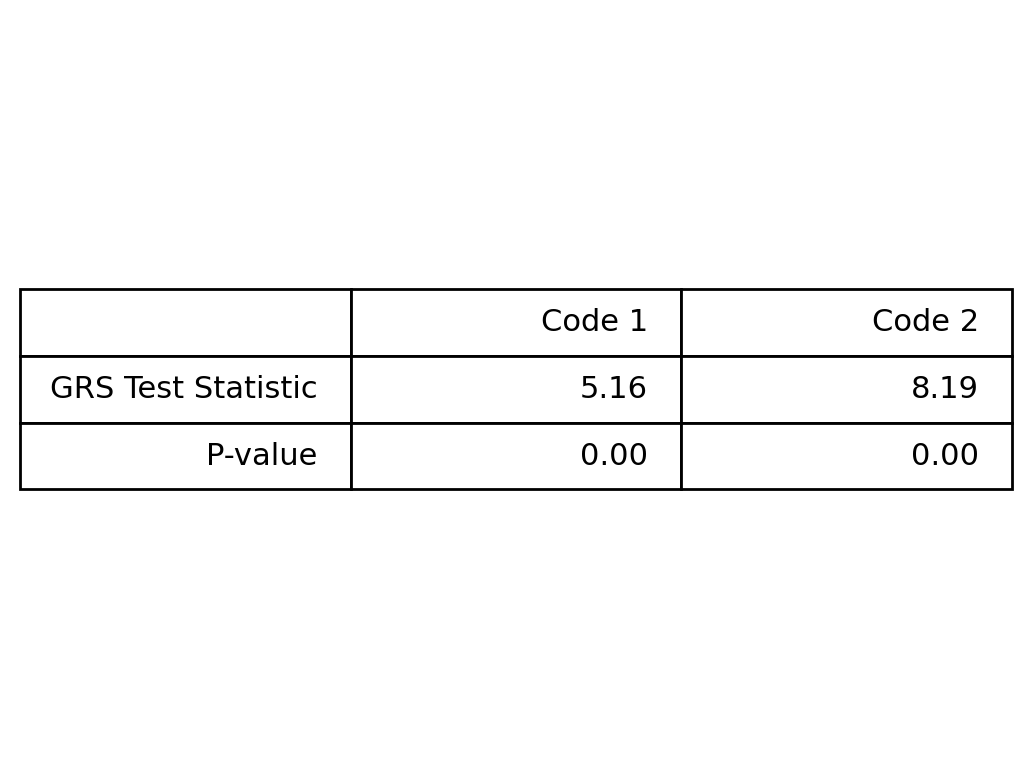

In [40]:
grs_result = [[grs, grs_2], [p_val, p_val_2]]
grs_result = pd.DataFrame(grs_result, index=['GRS Test Statistic', 'P-value'], columns=['Code 1', 'Code 2'], dtype=np.float64)
plot_table(grs_result, text_format='.2f')

The results of the GRS test for two different codes are provided in the table. The first column shows the results for Code 1, and the second column shows the results for Code 2. The GRS test statistic value for Code 1 is 5.158, and for Code 2, it is 8.187. The reason why the difference arises could be due to the pseudo-inverse method used in Code 2 and also due to machine epsilon.

A small p-value indicates that the test's null hypothesis can be rejected, and it suggests that the four-factor model cannot adequately explain the cross-section of asset returns. The p-value for Code 1 is 5.43e-06, which is very low. The p-value for Code 2 is 6.80e-10, a minimal value. The results of Code 1 and Code 2 align. Both suggest that the four-factor model is invalid and cannot capture all variations.

According to Gibbons, Ross, and Shanken (1989), the null hypothesis in the GRS test is that th coefficients of the asset pricing model are equal to those of the market index. In the context of the GRS test, a p-value of zero indicates that the null hypothesis can be rejected at any significance level. If the p-value is zero, it suggests strong evidence against this null hypothesis and that the asset pricing model cannot explain the variation in the data.

However, we noted that some studies had shown p-values close to zero in the GRS test, even for widely accepted models in the literature. For example, studies by Asness, Moskowitz, and Pedersen (2013), Fama and French (2018), and Hou, Xue, and Zhang (2015) have all reported p-values close to zero for various asset pricing models.

One possible reason for a p-value close to zero is that the time horizon is large enough to capture periods where portfolios have different factor sensitivities. However, the test is based on constant sensitivities. In this case, the GRS test would indicate that the asset pricing model significantly
differs from the market index since the actual sensitivities vary. Another reason for a p-value close to zero is that the asset pricing model being tested is a poor fit for the data, and the market index is a much better fit. In this case, the GRS test would indicate that the asset pricing model
cannot explain the variation in the data and is therefore rejected.

# References

1. Affleck-Graves, J. and Mcdonald, B. (1989). ‘Nonnormalities and Tests of Asset Pricing Theories’. The Journal of Finance, 44(4), pp.889–908.
2. Asness, C. (2011). ‘Momentum in Japan: The Exception that Proves the Rule’. The Journal of Portfolio Management, 37(4), pp.67-75.
3. Asness, C. S., Moskowitz, T. J. and Pedersen, L. H. (2013). ‘Value and Momentum Everywhere’. The Journal of Finance, 68(3), pp.929–985.
4. Fama, E. F. and French, K. R. (2011). ‘Size, Value, and Momentum in International Stock Returns’. Journal of Financial Economics, 105(3), pp.457-472.
5. Fama, E. F. and French, K. R. (2018). ‘Choosing factors’. Journal of Financial Economics, 128(2), pp.234-352.
6. Gibsons, M. R., Ross, A., and Shanken, J. (1989). ‘A Test of the Efficiency of a Given Portfolio’. The Econometric Society, 57(5), pp.1121-1152.
7. Hou, K., Xue, C., and Zhang, L. (2015). ‘Digesting Anomalies: An Investment Approach’. The Review of Financial Studies, 28(3), pp.650-705.
8. Lo, A., W. (2002). ‘The Statistics of Sharpe Ratios’. Financial Analysts Journal, 58(4), pp.36-52.
9. Yang, C., Li, C. A., and Hsu, S., (2017). ‘An Explanation of Financial Market Anomalies: Risk-Based or Behavioral View? A New Perspective on Financial Constraints’. Global Journal of Business Research, 11(2), pp.27-42.